In [174]:
import time
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer
import timm

from albumentations.pytorch.transforms import ToTensorV2
from sklearn import manifold
from matplotlib.offsetbox_tsne import OffsetImage, AnnotationBbox_tsne
from functools import partial
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.__version__

'1.9.0+cu102'

In [272]:
data_path = 'pokemon_jpg/pokemon_jpg/'
size = 128

x = np.array([
    cv2.resize(cv2.imread(data_path + name), (size, size))[..., ::-1]
    for name in os.listdir(data_path)
])

lens = len(x)

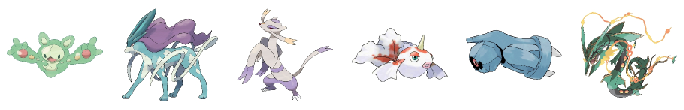

In [273]:
plt.figure(figsize=(12, 2))

indexes = np.random.choice(range(lens), 6, replace=False)
for i, idx in enumerate(indexes):
    plt.subplot(1, 6, i + 1)
    plt.imshow(x[idx])
    plt.axis('off')
plt.show()

In [43]:
# utils
class TrainDataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
        self.transform = transform
        self.totensor = A.Compose([
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        #tranformed = self.transform(image=self.x[idx], mask=self.x[idx])
        #x = tranformed['image']
        #y = tranformed['mask']
        #x = torch.FloatTensor(x.transpose((2, 0, 1)))/255.
        #y = torch.FloatTensor(y.transpose((2, 0, 1)))/255.
        # return x, y

        x = self.transform(image=self.x[idx])['image']
        x = torch.FloatTensor(x.transpose((2, 0, 1))) / 255.
        return x, x


def rescale_fn(in_c, out_c, direct):
    if direct == 'up':
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_c),
        )
    else:
        return nn.Sequential(nn.MaxPool2d(2, 2),
                             nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False),
                             nn.BatchNorm2d(out_c))


def conv3x3(in_c, out_c, k, s, p):
    return nn.Sequential(
        nn.Conv2d(in_c, in_c, k, s, p, groups=in_c, bias=False),
        nn.BatchNorm2d(in_c), nn.Mish(),
        nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False), nn.BatchNorm2d(out_c),
        nn.Mish())


class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, rescale='down'):
        super(ConvBlock, self).__init__()
        self.rescale = rescale
        if rescale == 'up':
            self.rescale_fn1 = rescale_fn(in_c, in_c, rescale)
            self.rescale_fn2 = rescale_fn(in_c, out_c, rescale)
            k, s, p = 3, 1, 1
        elif rescale == 'down':
            self.rescale_fn = rescale_fn(in_c, out_c, rescale)
            k, s, p = 3, 2, 1
        else:
            k, s, p = 3, 1, 1
            self.res = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_c),
            )
        

        self.conv1 = conv3x3(in_c, out_c, k, s, p)
        self.conv2 = conv3x3(out_c, out_c, 3, 1, p=1)
        self.act = nn.Mish()

    def forward(self, x):
        residual = x
        if self.rescale == 'up':
            x = self.rescale_fn1(x)
            residual = self.rescale_fn2(residual)

        x = self.act(self.conv1(x))
        x = self.conv2(x)

        if self.rescale == 'down':
            residual = self.rescale_fn(residual)
            
        if self.rescale == False:
            residual = self.res(residual)

        x += residual
        x = self.act(x)
        return x


class Encoder(nn.Module):
    def __init__(self, in_c=3, h_dim=128, z_dim=1024):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            conv3x3(3, 32, 3, 1, 1),
            ConvBlock(32, 32, rescale='down'),  # 32|64
            ConvBlock(32, 64, rescale='down'),  # 64|32
            ConvBlock(64, 64, rescale='down'),  # 64|16
            ConvBlock(64, 128, rescale='down'),  # 128|8
            ConvBlock(128, h_dim, rescale='down'),  # 128|4
            ConvBlock(h_dim, h_dim, rescale='down'),  # 128|2
            nn.Flatten(1),  # 512
        )

        #self.log_var = nn.Sequential(nn.Linear(h_dim * 4, z_dim), nn.Tanh())
        #self.mean = nn.Sequential(nn.Linear(h_dim * 4, z_dim), nn.Tanh())
        self.log_var = nn.Sequential(nn.Linear(h_dim * 4, z_dim))
        self.mean = nn.Sequential(nn.Linear(h_dim * 4, z_dim))

    def reparameter(self, x):
        log_var = self.log_var(x)
        #esp = torch.randn_like(log_var).to(device)
        std = (log_var * 0.5).exp()
        mean = self.mean(x)
        #return torch.tanh(mean + std * esp), mean, log_var
        return torch.distributions.Normal(mean, std).rsample(), mean, log_var

    def forward(self, x):
        bs = len(x)
        x = self.encoder(x)
        x, mean, log_var = self.reparameter(x.view(bs, -1))
        return x, mean, log_var

    def encode(self, x):
        x, _, _ = self.forward(x)
        return x


class Decoder(nn.Module):
    def __init__(self, z_dim=1024, out_c=3):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            ConvBlock(z_dim // 4, 128, rescale='up'),  # 256|8
            ConvBlock(128, 64, rescale='up'),  # 128|16
            ConvBlock(64, 32, rescale='up'),  # 64|32
            ConvBlock(32, 16, rescale='up'),  # 32|64
            ConvBlock(16, 8, rescale='up'),  # 32|128
            ConvBlock(8, 8, rescale=False),  # 32|128
            ConvBlock(8, out_c, rescale=False),  # 32|128
            conv3x3(out_c, out_c, 1, 1, 0),  # 3|128
            conv3x3(out_c, out_c, 1, 1, 0),  # 3|128
            nn.Sigmoid(),
        )

    def forward(self, x):
        bs = len(x)
        x = F.interpolate(x.view(bs, -1, 2, 2), size=4)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self, in_c=3, h_dim=128, z_dim=1024, out_c=3):
        super(VAE, self).__init__()
        self.encoder = Encoder(in_c, h_dim, z_dim)
        self.decoder = Decoder(z_dim, out_c)

    def forward(self, x):
        x, mean, log_var = self.encoder(x)
        x = self.decoder(x)
        return x, mean, log_var


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def to_numpy(x): return x.detach().cpu().numpy()


def unnormalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = np.array(mean) * 255.
    std = np.array(std) * 255.
    return (x.transpose((1, 2, 0)) * std + mean).astype(int)


def rmse(preds, ys): return ((preds - ys)**2).mean()**0.5


def trn_fn(model, device, trn_dl, criterion, optimizer, history=None):
    model.train()
    running_loss = AverageMeter()
    running_metric = AverageMeter()

    for idx, (xs, ys) in enumerate(trn_dl, 1):
        batch_size = len(xs)
        xs, ys = xs.to(device), ys.to(device)

        # forward
        preds, mean, log_var = model(xs)
        loss = criterion(preds, ys, mean, log_var)
        #reg_loss = 0.0
        # for params in model.parameters():
        #    reg_loss += torch.norm(params)
        #loss += reg_loss * 1e-2
        running_loss.update(loss.item(), batch_size)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metric
        score = metric(preds, ys)
        running_metric.update(score.item(), batch_size)

        # print
        if idx == len(trn_dl):
            print(
                f'[{idx:04d}/{len(trn_dl):04d}]\t',
                f'Loss: {running_loss.avg:.6f} | ',
                f'{metric.__name__}: {running_metric.avg:.6f}',
            )
    return running_loss.avg, running_metric.avg


def plot_result(dataset, model, size=2, nums=1, save=False, name='1.png'):
    model.eval()
    plt.figure(figsize=(nums * size, nums * size))

    indexes = np.random.choice(range(lens), nums, replace=False)
    for i, idx in enumerate(indexes):
        # label
        plt.subplot(nums, 2, 2 * i + 1)
        img = dataset[idx][1].to(device)
        plt.imshow(to_numpy(img).transpose(1, 2, 0))
        plt.axis('off')

        # predict
        plt.subplot(nums, 2, 2 * i + 2)
        preds, _, _ = model(img[None])
        plt.imshow(to_numpy(preds)[0].transpose(1, 2, 0))

        plt.axis('off')
        plt.tight_layout()
    if save:
        plt.savefig(name)
    plt.show()


def loss_fn(preds, ys, mean, logvar):
    loss = F.binary_cross_entropy(preds, ys)
    rmse_loss = rmse(preds, ys) * len(preds)
    kld = -0.5 * (1 + logvar - mean**2 - logvar.exp()).mean()
    return loss  + rmse_loss #+ kld

In [44]:
aug = A.Compose([
    A.HorizontalFlip(),
    A.RandomGamma(),
    A.Rotate(10),    
])

metric = rmse

epochs = 1000
bs = 32
lr = 3e-3

Train Epoch: 000
[0025/0025]	 Loss: 12.804654 |  rmse: 0.380348


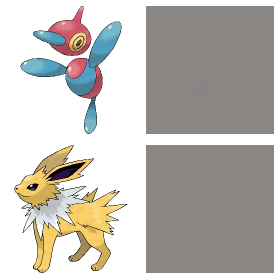

time: 0:3

Train Epoch: 001
[0025/0025]	 Loss: 10.593738 |  rmse: 0.314213
time: 0:3

Train Epoch: 002
[0025/0025]	 Loss: 8.625818 |  rmse: 0.255201
time: 0:3

Train Epoch: 003
[0025/0025]	 Loss: 7.482747 |  rmse: 0.220933
time: 0:3

Train Epoch: 004
[0025/0025]	 Loss: 6.943588 |  rmse: 0.204805
time: 0:3

Train Epoch: 005
[0025/0025]	 Loss: 6.752008 |  rmse: 0.199175
time: 0:3

Train Epoch: 006
[0025/0025]	 Loss: 6.653431 |  rmse: 0.196278
time: 0:3

Train Epoch: 007
[0025/0025]	 Loss: 6.453526 |  rmse: 0.190253
time: 0:3

Train Epoch: 008
[0025/0025]	 Loss: 6.399184 |  rmse: 0.188684
time: 0:3

Train Epoch: 009
[0025/0025]	 Loss: 6.313168 |  rmse: 0.186105
time: 0:3

Train Epoch: 010
[0025/0025]	 Loss: 6.228668 |  rmse: 0.183580
time: 0:3

Train Epoch: 011
[0025/0025]	 Loss: 6.189815 |  rmse: 0.182440
time: 0:3

Train Epoch: 012
[0025/0025]	 Loss: 6.096588 |  rmse: 0.179641
time: 0:3

Train Epoch: 013
[0025/0025]	 Loss: 6.042609 |  rmse: 0.178013
time: 0:3

Train Epoch: 014
[0025/002

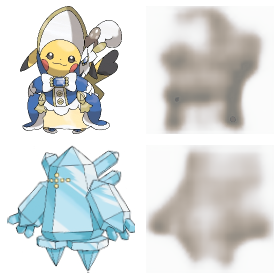

time: 0:4

Train Epoch: 051
[0025/0025]	 Loss: 5.247900 |  rmse: 0.154244
time: 0:4

Train Epoch: 052
[0025/0025]	 Loss: 5.229904 |  rmse: 0.153677
time: 0:4

Train Epoch: 053
[0025/0025]	 Loss: 5.225562 |  rmse: 0.153558
time: 0:4

Train Epoch: 054
[0025/0025]	 Loss: 5.214209 |  rmse: 0.153217
time: 0:4

Train Epoch: 055
[0025/0025]	 Loss: 5.172479 |  rmse: 0.151934
time: 0:4

Train Epoch: 056
[0025/0025]	 Loss: 5.185352 |  rmse: 0.152354
time: 0:4

Train Epoch: 057
[0025/0025]	 Loss: 5.252574 |  rmse: 0.154395
time: 0:4

Train Epoch: 058
[0025/0025]	 Loss: 5.165584 |  rmse: 0.151745
time: 0:4

Train Epoch: 059
[0025/0025]	 Loss: 5.165380 |  rmse: 0.151759
time: 0:4

Train Epoch: 060
[0025/0025]	 Loss: 5.154978 |  rmse: 0.151430
time: 0:4

Train Epoch: 061
[0025/0025]	 Loss: 5.170889 |  rmse: 0.151917
time: 0:4

Train Epoch: 062
[0025/0025]	 Loss: 5.136811 |  rmse: 0.150883
time: 0:4

Train Epoch: 063
[0025/0025]	 Loss: 5.127075 |  rmse: 0.150586
time: 0:4

Train Epoch: 064
[0025/0025

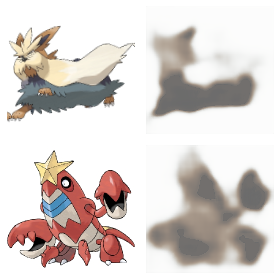

time: 0:4

Train Epoch: 101
[0025/0025]	 Loss: 4.904085 |  rmse: 0.143859
time: 0:4

Train Epoch: 102
[0025/0025]	 Loss: 4.905988 |  rmse: 0.143917
time: 0:4

Train Epoch: 103
[0025/0025]	 Loss: 4.934610 |  rmse: 0.144792
time: 0:4

Train Epoch: 104
[0025/0025]	 Loss: 4.905725 |  rmse: 0.143928
time: 0:4

Train Epoch: 105
[0025/0025]	 Loss: 4.883300 |  rmse: 0.143236
time: 0:4

Train Epoch: 106
[0025/0025]	 Loss: 4.908716 |  rmse: 0.144013
time: 0:4

Train Epoch: 107
[0025/0025]	 Loss: 4.869111 |  rmse: 0.142826
time: 0:4

Train Epoch: 108
[0025/0025]	 Loss: 4.878706 |  rmse: 0.143119
time: 0:4

Train Epoch: 109
[0025/0025]	 Loss: 4.853378 |  rmse: 0.142318
time: 0:4

Train Epoch: 110
[0025/0025]	 Loss: 4.886482 |  rmse: 0.143355
time: 0:4

Train Epoch: 111
[0025/0025]	 Loss: 4.857097 |  rmse: 0.142453
time: 0:4

Train Epoch: 112
[0025/0025]	 Loss: 4.843671 |  rmse: 0.142031
time: 0:4

Train Epoch: 113
[0025/0025]	 Loss: 4.851913 |  rmse: 0.142308
time: 0:4

Train Epoch: 114
[0025/0025

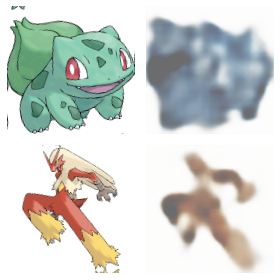

time: 0:4

Train Epoch: 151
[0025/0025]	 Loss: 4.646709 |  rmse: 0.136061
time: 0:4

Train Epoch: 152
[0025/0025]	 Loss: 4.641864 |  rmse: 0.135897
time: 0:4

Train Epoch: 153
[0025/0025]	 Loss: 4.630570 |  rmse: 0.135554
time: 0:4

Train Epoch: 154
[0025/0025]	 Loss: 4.620493 |  rmse: 0.135248
time: 0:4

Train Epoch: 155
[0025/0025]	 Loss: 4.611441 |  rmse: 0.134968
time: 0:4

Train Epoch: 156
[0025/0025]	 Loss: 4.624150 |  rmse: 0.135356
time: 0:4

Train Epoch: 157
[0025/0025]	 Loss: 4.617151 |  rmse: 0.135158
time: 0:4

Train Epoch: 158
[0025/0025]	 Loss: 4.600287 |  rmse: 0.134635
time: 0:4

Train Epoch: 159
[0025/0025]	 Loss: 4.605058 |  rmse: 0.134756
time: 0:4

Train Epoch: 160
[0025/0025]	 Loss: 4.598008 |  rmse: 0.134542
time: 0:4

Train Epoch: 161
[0025/0025]	 Loss: 4.632909 |  rmse: 0.135630
time: 0:4

Train Epoch: 162
[0025/0025]	 Loss: 4.604969 |  rmse: 0.134764
time: 0:4

Train Epoch: 163
[0025/0025]	 Loss: 4.609124 |  rmse: 0.134933
time: 0:4

Train Epoch: 164
[0025/0025

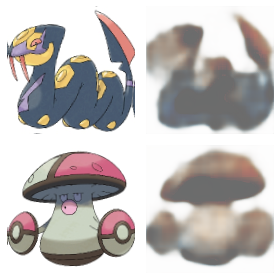

time: 0:4

Train Epoch: 201
[0025/0025]	 Loss: 4.465135 |  rmse: 0.130543
time: 0:4

Train Epoch: 202
[0025/0025]	 Loss: 4.432782 |  rmse: 0.129563
time: 0:4

Train Epoch: 203
[0025/0025]	 Loss: 4.475832 |  rmse: 0.130855
time: 0:4

Train Epoch: 204
[0025/0025]	 Loss: 4.473536 |  rmse: 0.130778
time: 0:4

Train Epoch: 205
[0025/0025]	 Loss: 4.472213 |  rmse: 0.130729
time: 0:4

Train Epoch: 206
[0025/0025]	 Loss: 4.474475 |  rmse: 0.130820
time: 0:4

Train Epoch: 207
[0025/0025]	 Loss: 4.491424 |  rmse: 0.131329
time: 0:4

Train Epoch: 208
[0025/0025]	 Loss: 4.459020 |  rmse: 0.130357
time: 0:4

Train Epoch: 209
[0025/0025]	 Loss: 4.468649 |  rmse: 0.130630
time: 0:4

Train Epoch: 210
[0025/0025]	 Loss: 4.453048 |  rmse: 0.130157
time: 0:4

Train Epoch: 211
[0025/0025]	 Loss: 4.456589 |  rmse: 0.130289
time: 0:4

Train Epoch: 212
[0025/0025]	 Loss: 4.492141 |  rmse: 0.131359
time: 0:4

Train Epoch: 213
[0025/0025]	 Loss: 4.476009 |  rmse: 0.130889
time: 0:4

Train Epoch: 214
[0025/0025

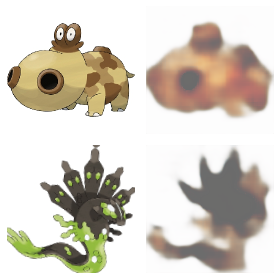

time: 0:4

Train Epoch: 251
[0025/0025]	 Loss: 4.405792 |  rmse: 0.128738
time: 0:4

Train Epoch: 252
[0025/0025]	 Loss: 4.379681 |  rmse: 0.127929
time: 0:4

Train Epoch: 253
[0025/0025]	 Loss: 4.353626 |  rmse: 0.127148
time: 0:4

Train Epoch: 254
[0025/0025]	 Loss: 4.353539 |  rmse: 0.127154
time: 0:4

Train Epoch: 255
[0025/0025]	 Loss: 4.415466 |  rmse: 0.129046
time: 0:4

Train Epoch: 256
[0025/0025]	 Loss: 4.379432 |  rmse: 0.127952
time: 0:4

Train Epoch: 257
[0025/0025]	 Loss: 4.383365 |  rmse: 0.128051
time: 0:4

Train Epoch: 258
[0025/0025]	 Loss: 4.367411 |  rmse: 0.127569
time: 0:4

Train Epoch: 259
[0025/0025]	 Loss: 4.361397 |  rmse: 0.127388
time: 0:4

Train Epoch: 260
[0025/0025]	 Loss: 4.381234 |  rmse: 0.127992
time: 0:4

Train Epoch: 261
[0025/0025]	 Loss: 4.363647 |  rmse: 0.127447
time: 0:4

Train Epoch: 262
[0025/0025]	 Loss: 4.370517 |  rmse: 0.127682
time: 0:4

Train Epoch: 263
[0025/0025]	 Loss: 4.358239 |  rmse: 0.127295
time: 0:4

Train Epoch: 264
[0025/0025

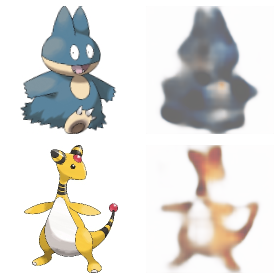

time: 0:4

Train Epoch: 301
[0025/0025]	 Loss: 4.337902 |  rmse: 0.126665
time: 0:4

Train Epoch: 302
[0025/0025]	 Loss: 4.328284 |  rmse: 0.126395
time: 0:4

Train Epoch: 303
[0025/0025]	 Loss: 4.330058 |  rmse: 0.126443
time: 0:4

Train Epoch: 304
[0025/0025]	 Loss: 4.332740 |  rmse: 0.126510
time: 0:4

Train Epoch: 305
[0025/0025]	 Loss: 4.324780 |  rmse: 0.126303
time: 0:4

Train Epoch: 306
[0025/0025]	 Loss: 4.318156 |  rmse: 0.126080
time: 0:4

Train Epoch: 307
[0025/0025]	 Loss: 4.311774 |  rmse: 0.125884
time: 0:4

Train Epoch: 308
[0025/0025]	 Loss: 4.277274 |  rmse: 0.124851
time: 0:4

Train Epoch: 309
[0025/0025]	 Loss: 4.303156 |  rmse: 0.125629
time: 0:4

Train Epoch: 310
[0025/0025]	 Loss: 4.329311 |  rmse: 0.126417
time: 0:4

Train Epoch: 311
[0025/0025]	 Loss: 4.311256 |  rmse: 0.125866
time: 0:4

Train Epoch: 312
[0025/0025]	 Loss: 4.294234 |  rmse: 0.125332
time: 0:4

Train Epoch: 313
[0025/0025]	 Loss: 4.299129 |  rmse: 0.125515
time: 0:4

Train Epoch: 314
[0025/0025

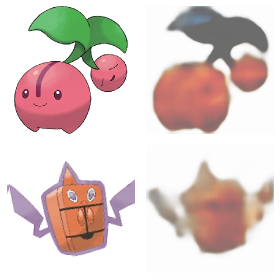

time: 0:4

Train Epoch: 351
[0025/0025]	 Loss: 4.269690 |  rmse: 0.124630
time: 0:4

Train Epoch: 352
[0025/0025]	 Loss: 4.262463 |  rmse: 0.124384
time: 0:4

Train Epoch: 353
[0025/0025]	 Loss: 4.275919 |  rmse: 0.124827
time: 0:4

Train Epoch: 354
[0025/0025]	 Loss: 4.264947 |  rmse: 0.124453
time: 0:4

Train Epoch: 355
[0025/0025]	 Loss: 4.253256 |  rmse: 0.124131
time: 0:4

Train Epoch: 356
[0025/0025]	 Loss: 4.215839 |  rmse: 0.122972
time: 0:4

Train Epoch: 357
[0025/0025]	 Loss: 4.257481 |  rmse: 0.124256
time: 0:4

Train Epoch: 358
[0025/0025]	 Loss: 4.262032 |  rmse: 0.124372
time: 0:4

Train Epoch: 359
[0025/0025]	 Loss: 4.250204 |  rmse: 0.124013
time: 0:4

Train Epoch: 360
[0025/0025]	 Loss: 4.266016 |  rmse: 0.124509
time: 0:4

Train Epoch: 361
[0025/0025]	 Loss: 4.255899 |  rmse: 0.124185
time: 0:4

Train Epoch: 362
[0025/0025]	 Loss: 4.257801 |  rmse: 0.124236
time: 0:4

Train Epoch: 363
[0025/0025]	 Loss: 4.252043 |  rmse: 0.124072
time: 0:4

Train Epoch: 364
[0025/0025

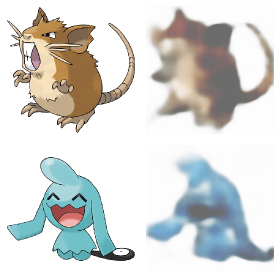

time: 0:4

Train Epoch: 401
[0025/0025]	 Loss: 4.249316 |  rmse: 0.123982
time: 0:4

Train Epoch: 402
[0025/0025]	 Loss: 4.238346 |  rmse: 0.123648
time: 0:4

Train Epoch: 403
[0025/0025]	 Loss: 4.195924 |  rmse: 0.122347
time: 0:4

Train Epoch: 404
[0025/0025]	 Loss: 4.204188 |  rmse: 0.122619
time: 0:4

Train Epoch: 405
[0025/0025]	 Loss: 4.213453 |  rmse: 0.122903
time: 0:4

Train Epoch: 406
[0025/0025]	 Loss: 4.224830 |  rmse: 0.123245
time: 0:4

Train Epoch: 407
[0025/0025]	 Loss: 4.220612 |  rmse: 0.123119
time: 0:4

Train Epoch: 408
[0025/0025]	 Loss: 4.207268 |  rmse: 0.122702
time: 0:4

Train Epoch: 409
[0025/0025]	 Loss: 4.204764 |  rmse: 0.122629
time: 0:4

Train Epoch: 410
[0025/0025]	 Loss: 4.202223 |  rmse: 0.122556
time: 0:4

Train Epoch: 411
[0025/0025]	 Loss: 4.162576 |  rmse: 0.121351
time: 0:4

Train Epoch: 412
[0025/0025]	 Loss: 4.206973 |  rmse: 0.122698
time: 0:4

Train Epoch: 413
[0025/0025]	 Loss: 4.168097 |  rmse: 0.121505
time: 0:4

Train Epoch: 414
[0025/0025

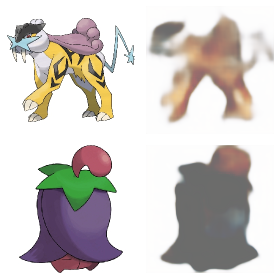

time: 0:4

Train Epoch: 451
[0025/0025]	 Loss: 4.159608 |  rmse: 0.121261
time: 0:3

Train Epoch: 452
[0025/0025]	 Loss: 4.157913 |  rmse: 0.121216
time: 0:4

Train Epoch: 453
[0025/0025]	 Loss: 4.147855 |  rmse: 0.120890
time: 0:4

Train Epoch: 454
[0025/0025]	 Loss: 4.182285 |  rmse: 0.121964
time: 0:4

Train Epoch: 455
[0025/0025]	 Loss: 4.186500 |  rmse: 0.122094
time: 0:4

Train Epoch: 456
[0025/0025]	 Loss: 4.165608 |  rmse: 0.121456
time: 0:4

Train Epoch: 457
[0025/0025]	 Loss: 4.163943 |  rmse: 0.121404
time: 0:4

Train Epoch: 458
[0025/0025]	 Loss: 4.183985 |  rmse: 0.121989
time: 0:4

Train Epoch: 459
[0025/0025]	 Loss: 4.152337 |  rmse: 0.121047
time: 0:4

Train Epoch: 460
[0025/0025]	 Loss: 4.182610 |  rmse: 0.121965
time: 0:4

Train Epoch: 461
[0025/0025]	 Loss: 4.161640 |  rmse: 0.121347
time: 0:4

Train Epoch: 462
[0025/0025]	 Loss: 4.177073 |  rmse: 0.121796
time: 0:4

Train Epoch: 463
[0025/0025]	 Loss: 4.182529 |  rmse: 0.121955
time: 0:4

Train Epoch: 464
[0025/0025

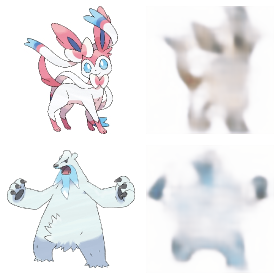

time: 0:4

Train Epoch: 501
[0025/0025]	 Loss: 4.141346 |  rmse: 0.120701
time: 0:4

Train Epoch: 502
[0025/0025]	 Loss: 4.159778 |  rmse: 0.121277
time: 0:4

Train Epoch: 503
[0025/0025]	 Loss: 4.161540 |  rmse: 0.121344
time: 0:4

Train Epoch: 504
[0025/0025]	 Loss: 4.160750 |  rmse: 0.121311
time: 0:4

Train Epoch: 505
[0025/0025]	 Loss: 4.136443 |  rmse: 0.120562
time: 0:4

Train Epoch: 506
[0025/0025]	 Loss: 4.125772 |  rmse: 0.120251
time: 0:4

Train Epoch: 507
[0025/0025]	 Loss: 4.112017 |  rmse: 0.119812
time: 0:4

Train Epoch: 508
[0025/0025]	 Loss: 4.122075 |  rmse: 0.120114
time: 0:4

Train Epoch: 509
[0025/0025]	 Loss: 4.102354 |  rmse: 0.119518
time: 0:4

Train Epoch: 510
[0025/0025]	 Loss: 4.121711 |  rmse: 0.120101
time: 0:4

Train Epoch: 511
[0025/0025]	 Loss: 4.112814 |  rmse: 0.119853
time: 0:4

Train Epoch: 512
[0025/0025]	 Loss: 4.112186 |  rmse: 0.119808
time: 0:4

Train Epoch: 513
[0025/0025]	 Loss: 4.111701 |  rmse: 0.119805
time: 0:4

Train Epoch: 514
[0025/0025

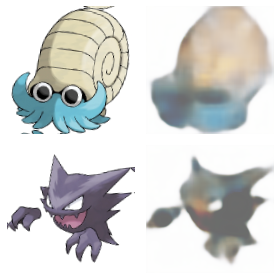

time: 0:4

Train Epoch: 551
[0025/0025]	 Loss: 4.099205 |  rmse: 0.119428
time: 0:4

Train Epoch: 552
[0025/0025]	 Loss: 4.105157 |  rmse: 0.119598
time: 0:4

Train Epoch: 553
[0025/0025]	 Loss: 4.117186 |  rmse: 0.119969
time: 0:4

Train Epoch: 554
[0025/0025]	 Loss: 4.091663 |  rmse: 0.119188
time: 0:4

Train Epoch: 555
[0025/0025]	 Loss: 4.097740 |  rmse: 0.119398
time: 0:4

Train Epoch: 556
[0025/0025]	 Loss: 4.096047 |  rmse: 0.119310
time: 0:4

Train Epoch: 557
[0025/0025]	 Loss: 4.139713 |  rmse: 0.120665
time: 0:4

Train Epoch: 558
[0025/0025]	 Loss: 4.106658 |  rmse: 0.119652
time: 0:4

Train Epoch: 559
[0025/0025]	 Loss: 4.102230 |  rmse: 0.119508
time: 0:4

Train Epoch: 560
[0025/0025]	 Loss: 4.124493 |  rmse: 0.120185
time: 0:4

Train Epoch: 561
[0025/0025]	 Loss: 4.121915 |  rmse: 0.120121
time: 0:4

Train Epoch: 562
[0025/0025]	 Loss: 4.110364 |  rmse: 0.119762
time: 0:4

Train Epoch: 563
[0025/0025]	 Loss: 4.116098 |  rmse: 0.119951
time: 0:4

Train Epoch: 564
[0025/0025

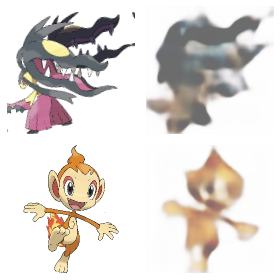

time: 0:4

Train Epoch: 601
[0025/0025]	 Loss: 4.086128 |  rmse: 0.119018
time: 0:4

Train Epoch: 602
[0025/0025]	 Loss: 4.098788 |  rmse: 0.119449
time: 0:4

Train Epoch: 603
[0025/0025]	 Loss: 4.086531 |  rmse: 0.119051
time: 0:4

Train Epoch: 604
[0025/0025]	 Loss: 4.077066 |  rmse: 0.118760
time: 0:4

Train Epoch: 605
[0025/0025]	 Loss: 4.086970 |  rmse: 0.119050
time: 0:4

Train Epoch: 606
[0025/0025]	 Loss: 4.074127 |  rmse: 0.118674
time: 0:4

Train Epoch: 607
[0025/0025]	 Loss: 4.090632 |  rmse: 0.119158
time: 0:4

Train Epoch: 608
[0025/0025]	 Loss: 4.101427 |  rmse: 0.119490
time: 0:4

Train Epoch: 609
[0025/0025]	 Loss: 4.085785 |  rmse: 0.119030
time: 0:4

Train Epoch: 610
[0025/0025]	 Loss: 4.061477 |  rmse: 0.118288
time: 0:4

Train Epoch: 611
[0025/0025]	 Loss: 4.071795 |  rmse: 0.118599
time: 0:4

Train Epoch: 612
[0025/0025]	 Loss: 4.075385 |  rmse: 0.118690
time: 0:4

Train Epoch: 613
[0025/0025]	 Loss: 4.059345 |  rmse: 0.118227
time: 0:4

Train Epoch: 614
[0025/0025

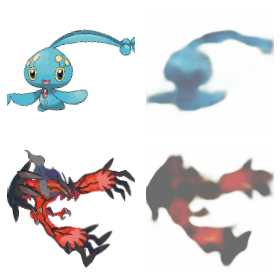

time: 0:4

Train Epoch: 651
[0025/0025]	 Loss: 4.043876 |  rmse: 0.117775
time: 0:4

Train Epoch: 652
[0025/0025]	 Loss: 4.043696 |  rmse: 0.117715
time: 0:4

Train Epoch: 653
[0025/0025]	 Loss: 4.043071 |  rmse: 0.117736
time: 0:4

Train Epoch: 654
[0025/0025]	 Loss: 4.034798 |  rmse: 0.117455
time: 0:4

Train Epoch: 655
[0025/0025]	 Loss: 4.034201 |  rmse: 0.117441
time: 0:4

Train Epoch: 656
[0025/0025]	 Loss: 4.054178 |  rmse: 0.118073
time: 0:4

Train Epoch: 657
[0025/0025]	 Loss: 4.049684 |  rmse: 0.117895
time: 0:4

Train Epoch: 658
[0025/0025]	 Loss: 4.051837 |  rmse: 0.117962
time: 0:4

Train Epoch: 659
[0025/0025]	 Loss: 4.037559 |  rmse: 0.117560
time: 0:4

Train Epoch: 660
[0025/0025]	 Loss: 4.052517 |  rmse: 0.118012
time: 0:4

Train Epoch: 661
[0025/0025]	 Loss: 4.029154 |  rmse: 0.117297
time: 0:4

Train Epoch: 662
[0025/0025]	 Loss: 4.058819 |  rmse: 0.118211
time: 0:4

Train Epoch: 663
[0025/0025]	 Loss: 4.042754 |  rmse: 0.117711
time: 0:4

Train Epoch: 664
[0025/0025

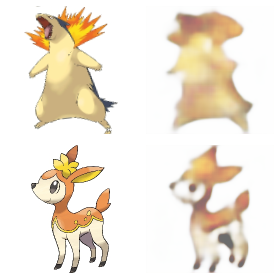

time: 0:4

Train Epoch: 701
[0025/0025]	 Loss: 4.024934 |  rmse: 0.117167
time: 0:4

Train Epoch: 702
[0025/0025]	 Loss: 4.032874 |  rmse: 0.117394
time: 0:4

Train Epoch: 703
[0025/0025]	 Loss: 4.018443 |  rmse: 0.116962
time: 0:4

Train Epoch: 704
[0025/0025]	 Loss: 4.013421 |  rmse: 0.116824
time: 0:4

Train Epoch: 705
[0025/0025]	 Loss: 4.005694 |  rmse: 0.116585
time: 0:4

Train Epoch: 706
[0025/0025]	 Loss: 4.024560 |  rmse: 0.117157
time: 0:4

Train Epoch: 707
[0025/0025]	 Loss: 4.015847 |  rmse: 0.116886
time: 0:4

Train Epoch: 708
[0025/0025]	 Loss: 4.024975 |  rmse: 0.117173
time: 0:4

Train Epoch: 709
[0025/0025]	 Loss: 4.052021 |  rmse: 0.118009
time: 0:4

Train Epoch: 710
[0025/0025]	 Loss: 4.041133 |  rmse: 0.117656
time: 0:4

Train Epoch: 711
[0025/0025]	 Loss: 4.012816 |  rmse: 0.116797
time: 0:4

Train Epoch: 712
[0025/0025]	 Loss: 4.019371 |  rmse: 0.116997
time: 0:4

Train Epoch: 713
[0025/0025]	 Loss: 4.025250 |  rmse: 0.117180
time: 0:4

Train Epoch: 714
[0025/0025

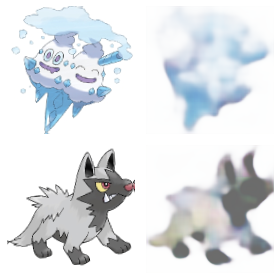

time: 0:4

Train Epoch: 751
[0025/0025]	 Loss: 3.999301 |  rmse: 0.116355
time: 0:4

Train Epoch: 752
[0025/0025]	 Loss: 4.001477 |  rmse: 0.116487
time: 0:4

Train Epoch: 753
[0025/0025]	 Loss: 3.980005 |  rmse: 0.115784
time: 0:4

Train Epoch: 754
[0025/0025]	 Loss: 4.000678 |  rmse: 0.116441
time: 0:4

Train Epoch: 755
[0025/0025]	 Loss: 4.007348 |  rmse: 0.116613
time: 0:4

Train Epoch: 756
[0025/0025]	 Loss: 3.990395 |  rmse: 0.116153
time: 0:4

Train Epoch: 757
[0025/0025]	 Loss: 3.971001 |  rmse: 0.115527
time: 0:4

Train Epoch: 758
[0025/0025]	 Loss: 3.987017 |  rmse: 0.115993
time: 0:4

Train Epoch: 759
[0025/0025]	 Loss: 3.991696 |  rmse: 0.116177
time: 0:4

Train Epoch: 760
[0025/0025]	 Loss: 4.036398 |  rmse: 0.117525
time: 0:4

Train Epoch: 761
[0025/0025]	 Loss: 3.984488 |  rmse: 0.115922
time: 0:4

Train Epoch: 762
[0025/0025]	 Loss: 3.997315 |  rmse: 0.116356
time: 0:4

Train Epoch: 763
[0025/0025]	 Loss: 4.021258 |  rmse: 0.117052
time: 0:4

Train Epoch: 764
[0025/0025

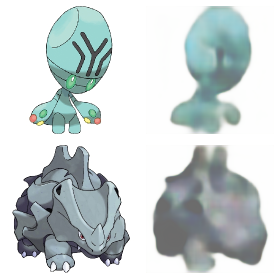

time: 0:4

Train Epoch: 801
[0025/0025]	 Loss: 3.956253 |  rmse: 0.115067
time: 0:4

Train Epoch: 802
[0025/0025]	 Loss: 3.963564 |  rmse: 0.115314
time: 0:4

Train Epoch: 803
[0025/0025]	 Loss: 3.942866 |  rmse: 0.114664
time: 0:4

Train Epoch: 804
[0025/0025]	 Loss: 3.973086 |  rmse: 0.115566
time: 0:4

Train Epoch: 805
[0025/0025]	 Loss: 3.968594 |  rmse: 0.115456
time: 0:4

Train Epoch: 806
[0025/0025]	 Loss: 3.957924 |  rmse: 0.115131
time: 0:4

Train Epoch: 807
[0025/0025]	 Loss: 3.963865 |  rmse: 0.115306
time: 0:4

Train Epoch: 808
[0025/0025]	 Loss: 3.955090 |  rmse: 0.115019
time: 0:4

Train Epoch: 809
[0025/0025]	 Loss: 3.946499 |  rmse: 0.114738
time: 0:4

Train Epoch: 810
[0025/0025]	 Loss: 3.963328 |  rmse: 0.115292
time: 0:4

Train Epoch: 811
[0025/0025]	 Loss: 3.941087 |  rmse: 0.114613
time: 0:4

Train Epoch: 812
[0025/0025]	 Loss: 3.965016 |  rmse: 0.115346
time: 0:4

Train Epoch: 813
[0025/0025]	 Loss: 3.954481 |  rmse: 0.115005
time: 0:4

Train Epoch: 814
[0025/0025

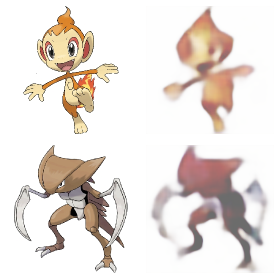

time: 0:4

Train Epoch: 851
[0025/0025]	 Loss: 3.942013 |  rmse: 0.114641
time: 0:4

Train Epoch: 852
[0025/0025]	 Loss: 3.973278 |  rmse: 0.115613
time: 0:4

Train Epoch: 853
[0025/0025]	 Loss: 3.967393 |  rmse: 0.115404
time: 0:4

Train Epoch: 854
[0025/0025]	 Loss: 3.957285 |  rmse: 0.115092
time: 0:4

Train Epoch: 855
[0025/0025]	 Loss: 3.960871 |  rmse: 0.115189
time: 0:4

Train Epoch: 856
[0025/0025]	 Loss: 3.955118 |  rmse: 0.115015
time: 0:4

Train Epoch: 857
[0025/0025]	 Loss: 3.947994 |  rmse: 0.114831
time: 0:4

Train Epoch: 858
[0025/0025]	 Loss: 3.940604 |  rmse: 0.114595
time: 0:4

Train Epoch: 859
[0025/0025]	 Loss: 3.940826 |  rmse: 0.114614
time: 0:4

Train Epoch: 860
[0025/0025]	 Loss: 3.949278 |  rmse: 0.114833
time: 0:4

Train Epoch: 861
[0025/0025]	 Loss: 3.949688 |  rmse: 0.114896
time: 0:4

Train Epoch: 862
[0025/0025]	 Loss: 3.934987 |  rmse: 0.114429
time: 0:4

Train Epoch: 863
[0025/0025]	 Loss: 3.925334 |  rmse: 0.114128
time: 0:4

Train Epoch: 864
[0025/0025

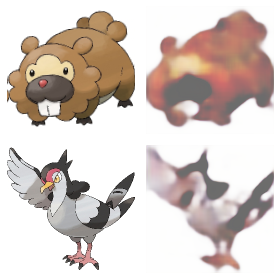

time: 0:4

Train Epoch: 901
[0025/0025]	 Loss: 3.886115 |  rmse: 0.112931
time: 0:4

Train Epoch: 902
[0025/0025]	 Loss: 3.938713 |  rmse: 0.114531
time: 0:4

Train Epoch: 903
[0025/0025]	 Loss: 3.909934 |  rmse: 0.113656
time: 0:4

Train Epoch: 904
[0025/0025]	 Loss: 3.920900 |  rmse: 0.114008
time: 0:4

Train Epoch: 905
[0025/0025]	 Loss: 3.896681 |  rmse: 0.113239
time: 0:4

Train Epoch: 906
[0025/0025]	 Loss: 3.913220 |  rmse: 0.113741
time: 0:4

Train Epoch: 907
[0025/0025]	 Loss: 3.942351 |  rmse: 0.114662
time: 0:4

Train Epoch: 908
[0025/0025]	 Loss: 3.919931 |  rmse: 0.113968
time: 0:4

Train Epoch: 909
[0025/0025]	 Loss: 3.920938 |  rmse: 0.113988
time: 0:4

Train Epoch: 910
[0025/0025]	 Loss: 3.903974 |  rmse: 0.113477
time: 0:4

Train Epoch: 911
[0025/0025]	 Loss: 3.894518 |  rmse: 0.113186
time: 0:4

Train Epoch: 912
[0025/0025]	 Loss: 3.922750 |  rmse: 0.114033
time: 0:4

Train Epoch: 913
[0025/0025]	 Loss: 3.910261 |  rmse: 0.113678
time: 0:4

Train Epoch: 914
[0025/0025

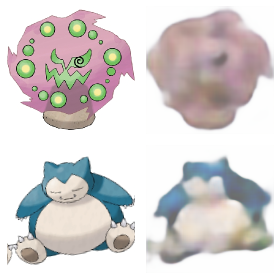

time: 0:4

Train Epoch: 951
[0025/0025]	 Loss: 3.920554 |  rmse: 0.113969
time: 0:4

Train Epoch: 952
[0025/0025]	 Loss: 3.918048 |  rmse: 0.113892
time: 0:4

Train Epoch: 953
[0025/0025]	 Loss: 3.921971 |  rmse: 0.114047
time: 0:4

Train Epoch: 954
[0025/0025]	 Loss: 3.927145 |  rmse: 0.114183
time: 0:4

Train Epoch: 955
[0025/0025]	 Loss: 3.913849 |  rmse: 0.113770
time: 0:4

Train Epoch: 956
[0025/0025]	 Loss: 3.898422 |  rmse: 0.113303
time: 0:4

Train Epoch: 957
[0025/0025]	 Loss: 3.915044 |  rmse: 0.113806
time: 0:4

Train Epoch: 958
[0025/0025]	 Loss: 3.926884 |  rmse: 0.114169
time: 0:4

Train Epoch: 959
[0025/0025]	 Loss: 3.890704 |  rmse: 0.113070
time: 0:4

Train Epoch: 960
[0025/0025]	 Loss: 3.926534 |  rmse: 0.114144
time: 0:4

Train Epoch: 961
[0025/0025]	 Loss: 3.904168 |  rmse: 0.113475
time: 0:4

Train Epoch: 962
[0025/0025]	 Loss: 3.888420 |  rmse: 0.112996
time: 0:4

Train Epoch: 963
[0025/0025]	 Loss: 3.882726 |  rmse: 0.112810
time: 0:4

Train Epoch: 964
[0025/0025

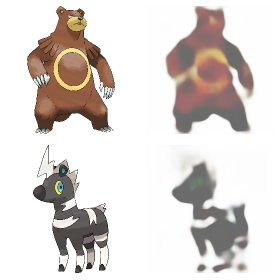

In [45]:
history = {
    'trn_losses_iter': [],
    f'trn_{metric.__name__}': [],
    'trn_losses': [],
    f'trn_{metric.__name__}': [],
    'val_losses': [],
    f'val_{metric.__name__}': [],
    'lrs': [],
}

trn_ds = TrainDataset(x, aug)
trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, drop_last=True)

model = VAE().to(device)
criterion = loss_fn
optimizer = torch_optimizer.AdaBelief(
    model.parameters(),
    lr=lr,
)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=250, gamma=0.5)
for epoch in range(epochs):
    start_time = time.time()
    print(f'Train Epoch: {epoch:03d}')
    trn_loss, trn_metric = trn_fn(model,
                                  device,
                                  trn_dl,
                                  criterion,
                                  optimizer,
                                  history=history
                                 )
    #scheduler.step()
    
    # calculate time
    end_time = time.time()
    m, s = divmod(end_time - start_time, 60)

    # record
    history['trn_losses'].append(trn_loss)
    history[f'trn_{metric.__name__}'].append(trn_metric)
    
    if epoch % 50 == 0:
        plot_result(trn_ds, model, nums=2, save=True, name=f'epoch-{epoch}.png')


    print(f'time: {m:.0f}:{s:.0f}\n')
    
plot_result(trn_ds, model, nums=2, save=True, name=f'epoch-1000.png')

In [63]:
# save
#torch.save(model.state_dict(), PATH)

# load
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()

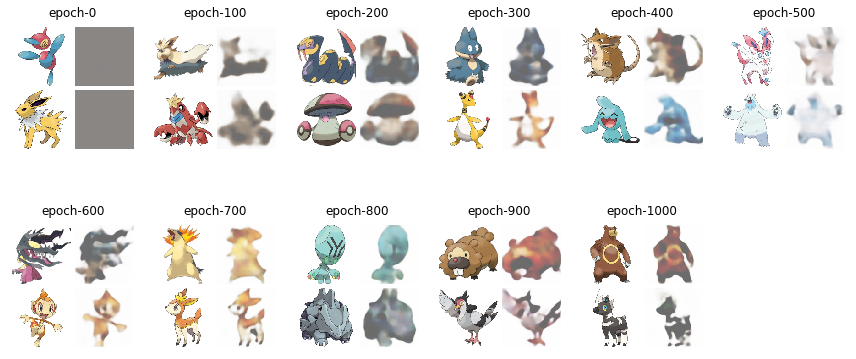

In [86]:
plt.figure(figsize=(12, 6))
for i, idx in enumerate(range(0, 1001, 100), 1):
    plt.subplot(2, 6, i)
    name = f'epoch-{idx}.png'
    img = cv2.imread(name)[..., ::-1]
    plt.imshow(img)
    plt.title(name[:-4])
    plt.axis('off')
plt.tight_layout()
plt.show()

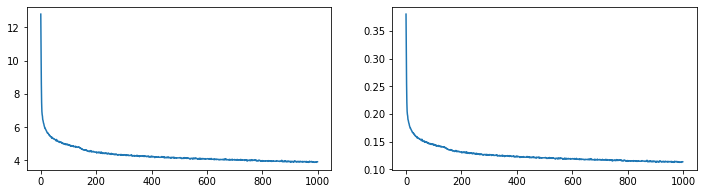

In [48]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(history['trn_losses'])
plt.subplot(1, 2, 2)
plt.plot(history[f'trn_{metric.__name__}'])

In [67]:
encoder = model.encoder
encoder.eval();
def preprocess(x):
    return torch.tensor(x.transpose((2, 0, 1)), device=device)[None] / 255.

features = []

for img in x:
    with torch.no_grad():
        img = preprocess(img)
        img = to_numpy(encoder.encode(img)[0])
        features.append(img)

features = np.array(features)

In [170]:
def cosine_similarity(x, y):
    '''
    x.shape: (m, n)
    y.shape: (1, n)
    '''
    return (x.dot(y.T) / 
            np.linalg.norm(x, axis=1, keepdims=True) /
            np.linalg.norm(y, axis=1, keepdims=True)).ravel()


def fine_similarity(features, idx, nums=5):
    similarity = cosine_similarity(features, features[idx:idx+1])
    nearest_index = np.argsort(similarity)[::-1][:nums]
    return nearest_index


def plt_similarity(features, imgs, idx, nums=5):
    nearest_index = fine_similarity(features, idx, nums)
    merge_img = np.concatenate([
        imgs[idx],
        np.zeros_like(imgs[idx])[:, :30],
        *[imgs[index] for index in nearest_index]
    ], axis=1)
    
    plt.figure(figsize=(15, 3))
    plt.imshow(merge_img.astype(int))
    plt.axis('off')
    plt.show()

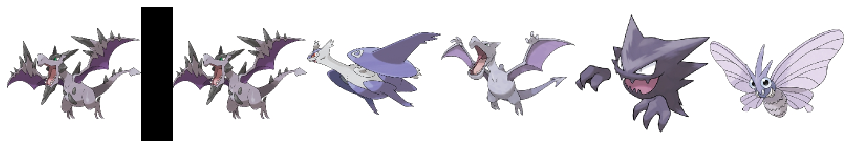

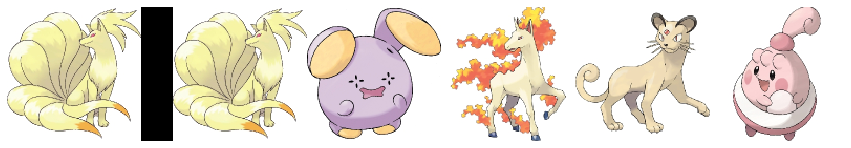

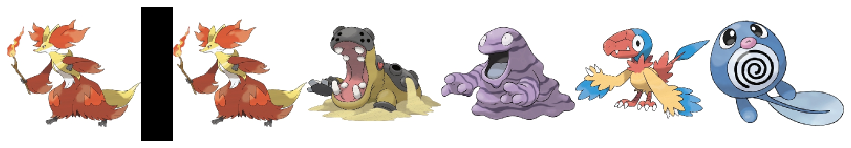

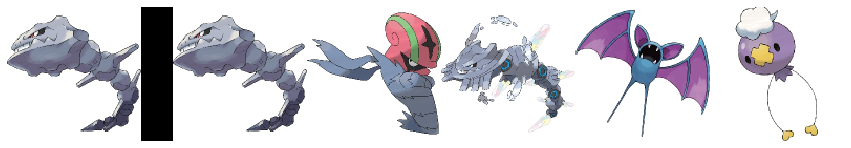

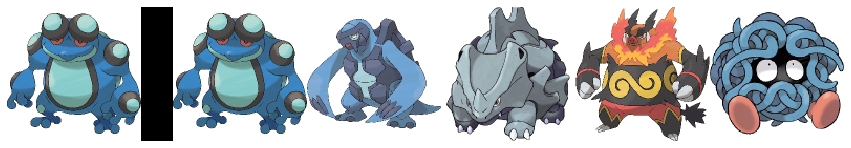

In [173]:
for _ in range(5):
    idx = random.choice(range(len(x)))
    plt_similarity(features, x, idx, nums=5)

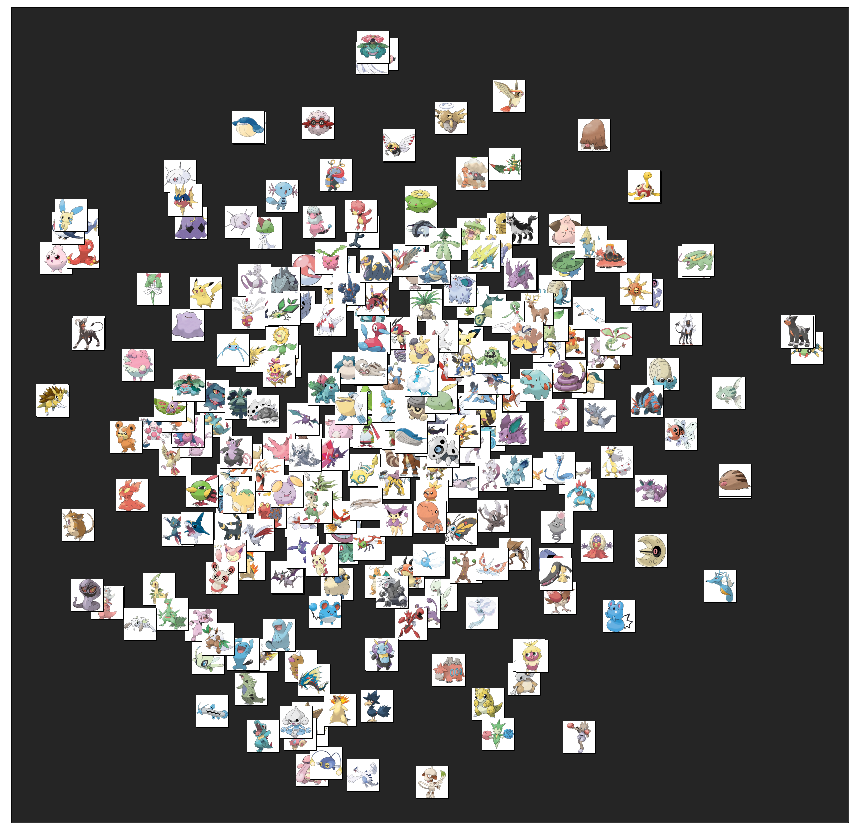

In [300]:
def plot_embedding(imgs, nums=30, background_color=(0., 0., 0., 0.85)):

    # get coordinate
    indexes = np.random.choice(range(len(imgs)), nums)
    tsne = manifold.TSNE(n_components=2, init='pca')
    x_tsne = tsne.fit_transform(features[indexes, :])

    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes()
    ax.set_facecolor(background_color)
    for i in range(nums):
        ax.scatter(*x_tsne[i])
        img = cv2.resize(x[i], (32, 32))
        ab = AnnotationBbox(OffsetImage(img, alpha=1.0), [*x_tsne[i]], pad=0)
        ax.add_artist(ab)
        
    # plt.axis('off') would clear background color
    plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_embedding(x, 300)